In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy.table import Table
import numpy.ma as ma

In [2]:
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['savefig.dpi'] = 300

In [3]:
master_table_fn = '/Users/nityaravi/Documents/Research/RotationCurves/data/manga/output_files/DR17/CURRENT_MASTER_TABLE/Elliptical_StelVelDispDAPMeanSigma_Mvir_smoothness_lt_2_dipole_vflag_comoving.fits'
master_table = Table.read(master_table_fn, format='fits')

In [4]:
master_table[0:5]

plate,ifudsgn,plateifu,mangaid,versdrp2,versdrp3,verscore,versutil,versprim,platetyp,srvymode,objra,objdec,ifuglon,ifuglat,ifura,ifudec,ebvgal,nexp,exptime,drp3qual,bluesn2,redsn2,harname,frlplug,cartid,designid,cenra,cendec,airmsmin,airmsmed,airmsmax,seemin,seemed,seemax,transmin,transmed,transmax,mjdmin,mjdmed,mjdmax,gfwhm,rfwhm,ifwhm,zfwhm,mngtarg1,mngtarg2,mngtarg3,catidnum,plttarg,manga_tileid,nsa_iauname,ifudesignsize,ifutargetsize,ifudesignwrongsize,z,zmin,zmax,szmin,szmax,ezmin,ezmax,probs,pweight,psweight,psrweight,sweight,srweight,eweight,esweight,esrweight,nsa_field,nsa_run,nsa_camcol,nsa_version,nsa_nsaid,nsa_nsaid_v1b,nsa_z,nsa_zdist,nsa_sersic_absmag,nsa_elpetro_absmag,nsa_elpetro_amivar,nsa_sersic_mass,nsa_elpetro_mass,nsa_elpetro_ba,nsa_elpetro_phi,nsa_extinction,nsa_elpetro_th50_r,nsa_petro_th50,nsa_petro_flux,nsa_petro_flux_ivar,nsa_elpetro_flux,nsa_elpetro_flux_ivar,nsa_sersic_ba,nsa_sersic_n,nsa_sersic_phi,nsa_sersic_th50,nsa_sersic_flux,nsa_sersic_flux_ivar,smoothness_score,nsa_elpetro_th90,v_sys,v_sys_err,ba,ba_err,x0,x0_err,y0,y0_err,phi,phi_err,v_max,v_max_err,r_turn,r_turn_err,chi2,alpha,alpha_err,Rmax,M,M_err,fit_flag,Sigma_disk,Sigma_disk_err,R_disk,R_disk_err,rho_bulge,rho_bulge_err,R_bulge,R_bulge_err,M90_disk,M90_disk_err,M_disk,M_disk_err,chi2_disk,logHI,logHIlim,WF50,WF50_err,DL_ttype,vis_tidal,b,b_err,M_R90,M_R90_err,fit_function,A_g,A_r,logH2,R90_kpc,v_3p5,v_3p5_err,NSA_plate,NSA_fiberID,NSA_MJD,logH2_CG,logH2_CG_err,logH2_M,Z,Z_err,M_Z,M_Z_err,grad_Z,grad_Z_err,Z_0,Z_0_err,SFR,sSFR,SFR_err,sSFR_err,Flux_OII_3726,Flux_OII_3726_Err,Flux_OII_3728,Flux_OII_3728_Err,Flux_OIII_4958,Flux_OIII_4958_Err,Flux_OIII_5006,Flux_OIII_5006_Err,Flux_NII_6547,Flux_NII_6547_Err,Flux_NII_6583,Flux_NII_6583_Err,Flux_Ha_6562,Flux_Ha_6562_Err,Flux_Hb_4861,Flux_Hb_4861_Err,CMD_class,rabsmag_NSA,param_H2,param_H2_err,Z_map,Z_err_map,M_Z_map,M_Z_err_map,logHI_R90,Mvir,Mvir_err,star_sigma,star_sigma_err,dipole_moment,Rgal,vflag_VF
int64,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,bytes53,int64,bytes32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,bytes32,int64,bytes19,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,bytes6,int64,int64,float64,float64,float64[7],float64[7],float64[7],float64,float64,float64,float64,float64[7],float64,float64,float64[7],float64[7],float64[7],float64[7],float64,float64,float64,float64,float64[7],float64[7],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,int64
10001,12701,10001-12701,1-48157,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,133.371090612,57.5984251446,159.27921887,38.8381829181,133.37109,57.598425,0.0545561,9,8100.81,0,20.0835,41.292,ma079,22,3,9114,134.41357,57.604214,1.10715,1.15321,1.21404,1.78219,1.85994,2.12685,0.898721,0.929654,0.937466,57372,57373,57373,2.69906,2.64546,2.59645,2.54039,2080,0,0,1,plateTargets-1.par,6013,J085329.03+573554.9,127,127,0,

In [5]:
ellipticals = master_table[master_table['Mvir'] > 0]

# Get sample of spirals with cuts

1. vmax > 0
2. m90_disk > 0
3. 10 > v90 > 1000
4. alpha < 99
5. vmax_err/vmax < 2
6. stellar mass > 9

In [6]:
spirals = master_table[master_table['v_max'] > 0]
spirals = spirals[spirals['M90_disk'] > 0]
spirals = spirals[spirals['alpha'] <= 99]
spirals = spirals[spirals['v_max_err']/spirals['v_max'] <= 2]

In [7]:
v90 = spirals['v_max'] * spirals['R90_kpc'] / (spirals['r_turn']**spirals['alpha'] + spirals['R90_kpc']**spirals['alpha'])**(1/spirals['alpha'])

In [8]:
all_mass_spirals = spirals[np.logical_and(v90 > 10, v90 < 1000)]
spirals = all_mass_spirals[all_mass_spirals['M90_disk']>9]

## get magnitudes

In [9]:
e_mag = np.zeros(len(ellipticals))
s_mag = np.zeros(len(spirals))

for i in range(len(e_mag)):
    e_mag[i] = ellipticals['nsa_elpetro_absmag'][i][4]
    

for i in range(len(s_mag)):
    s_mag[i] = spirals['nsa_elpetro_absmag'][i][4]

## make plots

In [10]:
plot_dir = '/Users/nityaravi/Documents/Research/RotationCurves/data/manga/Ellipticals_Images/results_plots/'

In [11]:
Mvir = ellipticals['Mvir']
Mstar = np.log10(ellipticals['nsa_sersic_mass'])
bins=np.histogram(np.hstack((Mvir,Mstar)), bins=10)[1]

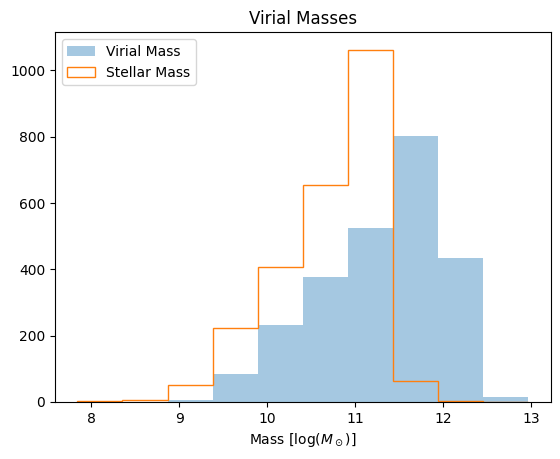

In [12]:
plt.hist(Mvir, label='Virial Mass', histtype='stepfilled', alpha=0.4, bins=bins)
plt.hist(Mstar, label='Stellar Mass', histtype='step', bins=bins)
plt.xlabel(r'Mass [$\log(M_\odot)$]')
plt.legend(loc='upper left')
plt.title('Virial Masses')
#plt.savefig(plot_dir + 'mass_distributions.png')
plt.show()

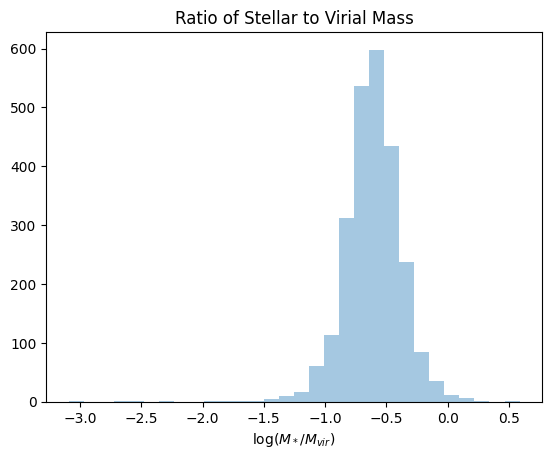

In [13]:
plt.hist(Mstar - Mvir, histtype='stepfilled', alpha=0.4, bins=30)
plt.xlabel('log($M_*/M_{vir}$)')
plt.title('Ratio of Stellar to Virial Mass')
#plt.savefig(plot_dir + 'mass_ratios.png')
plt.show()

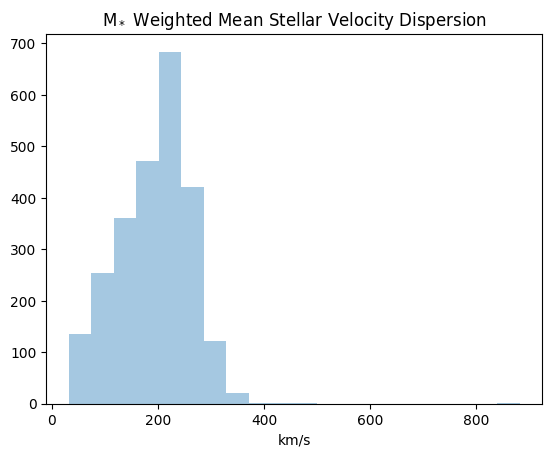

In [14]:
plt.hist(ellipticals['star_sigma'], histtype='stepfilled', alpha=0.4, bins=20)
plt.xlabel('km/s')
plt.title(r'M$_*$ Weighted Mean Stellar Velocity Dispersion')
#plt.savefig(plot_dir + 'median_sigma.png')
plt.show()

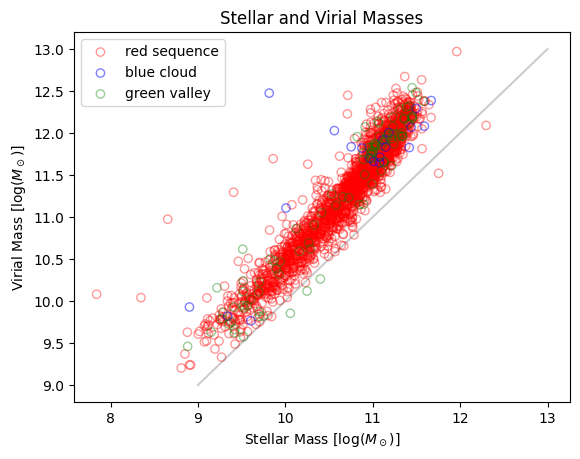

In [15]:
plt.scatter(Mstar[ellipticals['CMD_class'] == 3], Mvir[ellipticals['CMD_class'] == 3], 
            alpha=0.4, color = 'r', label='red sequence', facecolor='none')
plt.scatter(Mstar[ellipticals['CMD_class'] == 1], Mvir[ellipticals['CMD_class'] == 1], 
            color = 'b', alpha=0.5, label='blue cloud', facecolor='none')
plt.scatter(Mstar[ellipticals['CMD_class'] == 2], Mvir[ellipticals['CMD_class'] == 2], 
            alpha=0.4, color = 'g', label='green valley', facecolor='none')
plt.legend()
plt.ylabel(r'Virial Mass [$\log (M_\odot)$]')
plt.xlabel(r'Stellar Mass [$\log (M_\odot)$]')
plt.plot([9,13],[9,13],color='k',alpha=0.2)
plt.title('Stellar and Virial Masses')
#plt.savefig(plot_dir + 'mass_scatter.png')
plt.show()

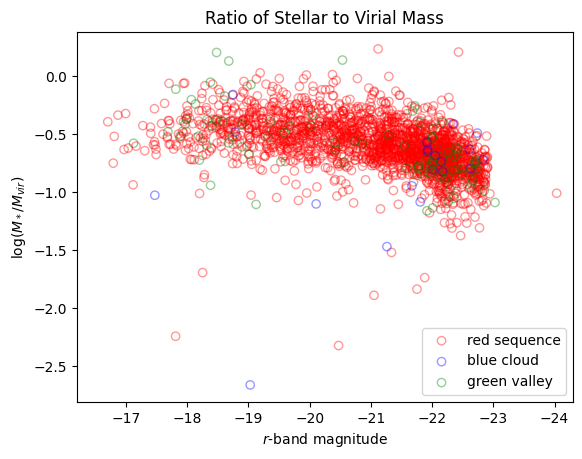

In [16]:
plt.scatter(e_mag[ellipticals['CMD_class'] == 3], Mstar[ellipticals['CMD_class'] == 3] - Mvir[ellipticals['CMD_class'] == 3], 
            alpha=0.4, color='r', label='red sequence', facecolor='none')
plt.scatter(e_mag[ellipticals['CMD_class'] == 1], Mstar[ellipticals['CMD_class'] == 1] - Mvir[ellipticals['CMD_class'] == 1], 
            alpha=0.4, color='b', label='blue cloud', facecolor='none')
plt.scatter(e_mag[ellipticals['CMD_class'] == 2], Mstar[ellipticals['CMD_class'] == 2] - Mvir[ellipticals['CMD_class'] == 2], 
            alpha=0.4, color='g', label='green valley', facecolor='none')

plt.legend()
plt.xlim(-16.2,-24.3)
plt.xlabel('$r$-band magnitude')
plt.title('Ratio of Stellar to Virial Mass')
plt.ylabel(r'$\log(M_*/M_{vir})$')
#plt.savefig(plot_dir + 'mag_mratio.png')
plt.show()

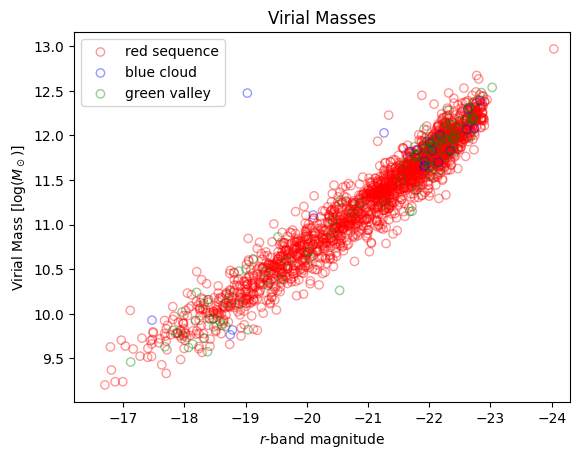

In [17]:
plt.scatter(e_mag[ellipticals['CMD_class'] == 3], Mvir[ellipticals['CMD_class'] == 3], 
            facecolor='none', color='r', alpha=0.4, label='red sequence')
plt.scatter(e_mag[ellipticals['CMD_class'] == 1], Mvir[ellipticals['CMD_class'] == 1], 
            facecolor='none', color='b', alpha=0.4, label='blue cloud')
plt.scatter(e_mag[ellipticals['CMD_class'] == 2], Mvir[ellipticals['CMD_class'] == 2], 
            facecolor='none', color='g', alpha=0.4, label='green valley')

plt.legend()
plt.xlabel('$r$-band magnitude')
plt.ylabel(r'Virial Mass [$\log(M_\odot)$]')
plt.title('Virial Masses')
plt.xlim(-16.2,-24.3)
#plt.savefig(plot_dir + 'mag_mvir_smoothness_lt_2.png')
plt.show()

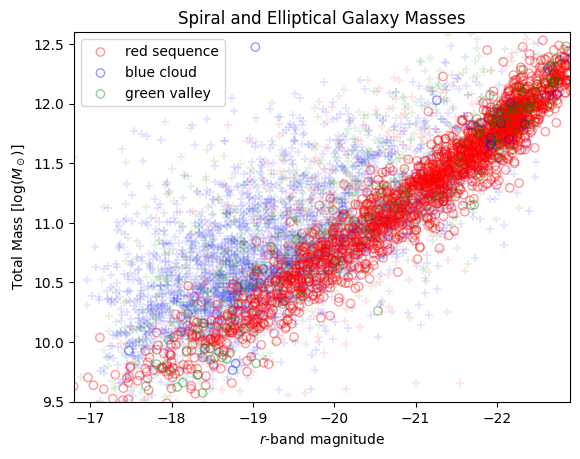

In [18]:
plt.scatter(s_mag[spirals['CMD_class'] == 1], spirals['M_R90'][spirals['CMD_class'] == 1], color='b', alpha=0.1, marker='+')
plt.scatter(s_mag[spirals['CMD_class'] == 2], spirals['M_R90'][spirals['CMD_class'] == 2], color='g', alpha=0.1,marker='+')
plt.scatter(s_mag[spirals['CMD_class'] == 3], spirals['M_R90'][spirals['CMD_class'] == 3], color='r', alpha=0.1,marker='+')
plt.scatter(e_mag[ellipticals['CMD_class'] == 3], Mvir[ellipticals['CMD_class'] == 3], 
            color='r', alpha=0.4, label='red sequence', facecolor='none')
plt.scatter(e_mag[ellipticals['CMD_class'] == 1], Mvir[ellipticals['CMD_class'] == 1], 
            color='b', alpha=0.4, label='blue cloud', facecolor='none')
plt.scatter(e_mag[ellipticals['CMD_class'] == 2], Mvir[ellipticals['CMD_class'] == 2], 
            color='g', alpha=0.4, label='green valley', facecolor='none')


plt.legend()
plt.xlabel('$r$-band magnitude')
plt.ylabel(r'Total Mass [$\log(M_\odot)$]')
plt.title('Spiral and Elliptical Galaxy Masses')
plt.xlim(-16.8,-22.9)
plt.ylim(9.5,12.6)
#plt.savefig(plot_dir + 'mag_totmass_allmorph_zoom.png')
plt.show()

In [19]:
dipoles = master_table[master_table['dipole_moment'] > 0]

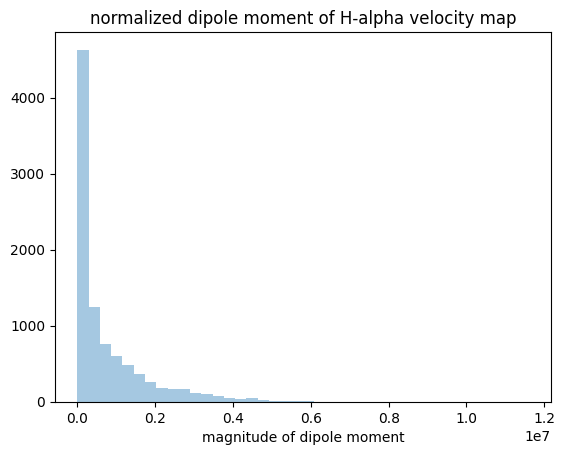

In [20]:
hist, bins, _ = plt.hist(dipoles['dipole_moment'], bins=40, alpha=0.4)

logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.title('normalized dipole moment of H-alpha velocity map')
plt.xlabel('magnitude of dipole moment')
plt.savefig(plot_dir + 'norm_dipole_moment.png')

Text(0.5, 0, 'magnitude of dipole moment')

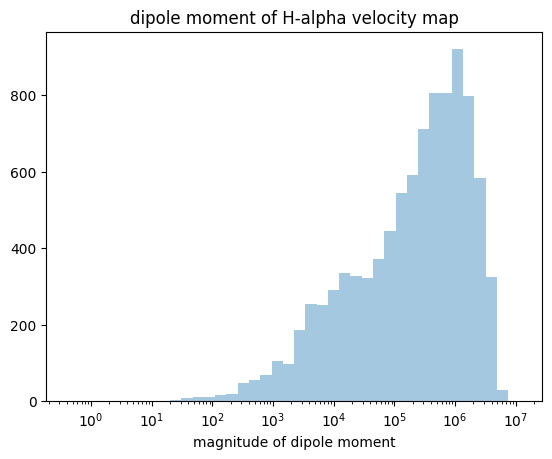

In [21]:
plt.hist(dipoles['dipole_moment'], bins=logbins, alpha=0.4)
plt.xscale('log')
plt.title('dipole moment of H-alpha velocity map')
plt.xlabel('magnitude of dipole moment')
#plt.savefig(plot_dir + 'norm_dipole_moment_log.png')

Text(0.5, 0, 'magnitude of dipole moment')

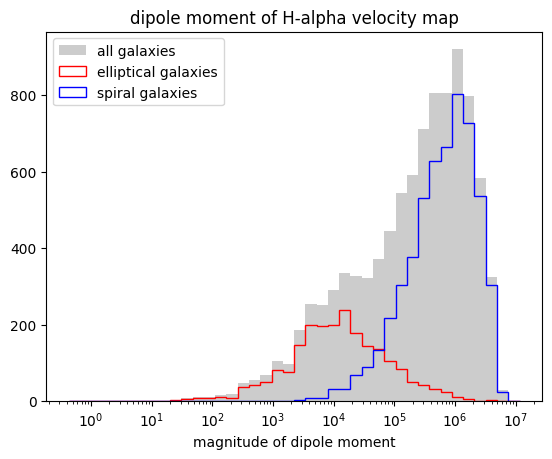

In [22]:
plt.hist(dipoles['dipole_moment'], bins=logbins, alpha=0.2, color='k', label='all galaxies')
plt.hist(dipoles[dipoles['Mvir'] > 0]['dipole_moment'], bins=logbins, histtype='step', color='r', label='elliptical galaxies')
plt.hist(spirals['dipole_moment'], bins=logbins, histtype='step', color='b', label='spiral galaxies')
plt.xscale('log')
plt.legend()
plt.title('dipole moment of H-alpha velocity map')
plt.xlabel('magnitude of dipole moment')
#plt.savefig(plot_dir + 'norm_dipole_moment_log_morph.png')

## plot stellar vs. total mass for all galaxies

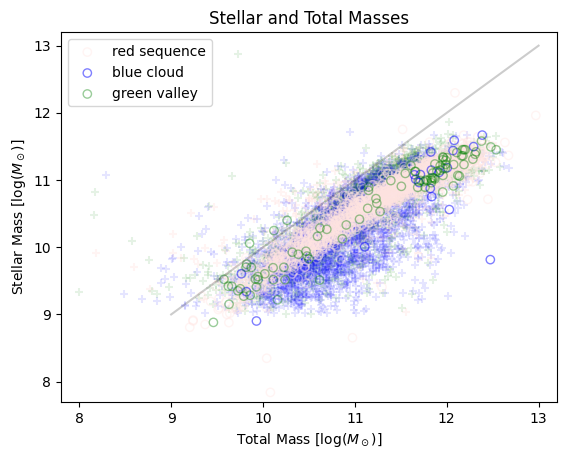

In [23]:
plt.scatter(spirals[spirals['CMD_class']==3]['M_R90'],spirals[spirals['CMD_class']==3]['M90_disk'],
            alpha=0.4, color='mistyrose', marker='+')
plt.scatter(spirals[spirals['CMD_class']==2]['M_R90'],spirals[spirals['CMD_class']==2]['M90_disk'],
            alpha=0.1, color='g', marker='+')
plt.scatter(spirals[spirals['CMD_class']==1]['M_R90'],spirals[spirals['CMD_class']==1]['M90_disk'],
            alpha=0.1, color='b', marker='+')


plt.scatter(Mvir[ellipticals['CMD_class'] == 3], Mstar[ellipticals['CMD_class'] == 3],
            alpha=0.4, color = 'mistyrose', label='red sequence', facecolor='none')
plt.scatter(Mvir[ellipticals['CMD_class'] == 1], Mstar[ellipticals['CMD_class'] == 1],
            color = 'b', alpha=0.5, label='blue cloud', facecolor='none')
plt.scatter(Mvir[ellipticals['CMD_class'] == 2], Mstar[ellipticals['CMD_class'] == 2],
            alpha=0.4, color = 'g', label='green valley', facecolor='none')
plt.legend()
plt.xlabel(r'Total Mass [$\log (M_\odot)$]')
plt.ylabel(r'Stellar Mass [$\log (M_\odot)$]')
plt.plot([9,13],[9,13],color='k',alpha=0.2)
plt.ylim(7.7,13.2)
plt.xlim(7.8,13.2)
plt.title('Stellar and Total Masses')
#plt.savefig(plot_dir + 'mass_scatter_morph.png')
plt.show()

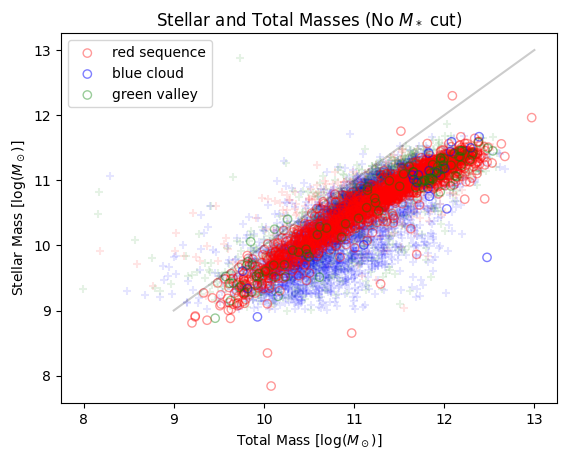

In [24]:
plt.scatter(spirals[spirals['CMD_class']==3]['M_R90'],spirals[spirals['CMD_class']==3]['M90_disk'],
            alpha=0.1, color='r', marker='+')
plt.scatter(spirals[spirals['CMD_class']==2]['M_R90'],spirals[spirals['CMD_class']==2]['M90_disk'],
            alpha=0.1, color='g', marker='+')
plt.scatter(spirals[spirals['CMD_class']==1]['M_R90'],spirals[spirals['CMD_class']==1]['M90_disk'],
            alpha=0.1, color='b', marker='+')


plt.scatter(Mvir[ellipticals['CMD_class'] == 3], Mstar[ellipticals['CMD_class'] == 3],
            alpha=0.4, color = 'r', label='red sequence', facecolor='none')
plt.scatter(Mvir[ellipticals['CMD_class'] == 1], Mstar[ellipticals['CMD_class'] == 1],
            color = 'b', alpha=0.5, label='blue cloud', facecolor='none')
plt.scatter(Mvir[ellipticals['CMD_class'] == 2], Mstar[ellipticals['CMD_class'] == 2],
            alpha=0.4, color = 'g', label='green valley', facecolor='none')
plt.legend()
plt.xlabel(r'Total Mass [$\log (M_\odot)$]')
plt.ylabel(r'Stellar Mass [$\log (M_\odot)$]')
plt.plot([9,13],[9,13],color='k',alpha=0.2)
plt.title(r'Stellar and Total Masses (No $M_*$ cut)')
#plt.savefig(plot_dir + 'mass_scatter_morph_allmass.png')
plt.show()

In [25]:
all_mass_spirals[all_mass_spirals['M90_disk'] < 9]

plate,ifudsgn,plateifu,mangaid,versdrp2,versdrp3,verscore,versutil,versprim,platetyp,srvymode,objra,objdec,ifuglon,ifuglat,ifura,ifudec,ebvgal,nexp,exptime,drp3qual,bluesn2,redsn2,harname,frlplug,cartid,designid,cenra,cendec,airmsmin,airmsmed,airmsmax,seemin,seemed,seemax,transmin,transmed,transmax,mjdmin,mjdmed,mjdmax,gfwhm,rfwhm,ifwhm,zfwhm,mngtarg1,mngtarg2,mngtarg3,catidnum,plttarg,manga_tileid,nsa_iauname,ifudesignsize,ifutargetsize,ifudesignwrongsize,z,zmin,zmax,szmin,szmax,ezmin,ezmax,probs,pweight,psweight,psrweight,sweight,srweight,eweight,esweight,esrweight,nsa_field,nsa_run,nsa_camcol,nsa_version,nsa_nsaid,nsa_nsaid_v1b,nsa_z,nsa_zdist,nsa_sersic_absmag,nsa_elpetro_absmag,nsa_elpetro_amivar,nsa_sersic_mass,nsa_elpetro_mass,nsa_elpetro_ba,nsa_elpetro_phi,nsa_extinction,nsa_elpetro_th50_r,nsa_petro_th50,nsa_petro_flux,nsa_petro_flux_ivar,nsa_elpetro_flux,nsa_elpetro_flux_ivar,nsa_sersic_ba,nsa_sersic_n,nsa_sersic_phi,nsa_sersic_th50,nsa_sersic_flux,nsa_sersic_flux_ivar,smoothness_score,nsa_elpetro_th90,v_sys,v_sys_err,ba,ba_err,x0,x0_err,y0,y0_err,phi,phi_err,v_max,v_max_err,r_turn,r_turn_err,chi2,alpha,alpha_err,Rmax,M,M_err,fit_flag,Sigma_disk,Sigma_disk_err,R_disk,R_disk_err,rho_bulge,rho_bulge_err,R_bulge,R_bulge_err,M90_disk,M90_disk_err,M_disk,M_disk_err,chi2_disk,logHI,logHIlim,WF50,WF50_err,DL_ttype,vis_tidal,b,b_err,M_R90,M_R90_err,fit_function,A_g,A_r,logH2,R90_kpc,v_3p5,v_3p5_err,NSA_plate,NSA_fiberID,NSA_MJD,logH2_CG,logH2_CG_err,logH2_M,Z,Z_err,M_Z,M_Z_err,grad_Z,grad_Z_err,Z_0,Z_0_err,SFR,sSFR,SFR_err,sSFR_err,Flux_OII_3726,Flux_OII_3726_Err,Flux_OII_3728,Flux_OII_3728_Err,Flux_OIII_4958,Flux_OIII_4958_Err,Flux_OIII_5006,Flux_OIII_5006_Err,Flux_NII_6547,Flux_NII_6547_Err,Flux_NII_6583,Flux_NII_6583_Err,Flux_Ha_6562,Flux_Ha_6562_Err,Flux_Hb_4861,Flux_Hb_4861_Err,CMD_class,rabsmag_NSA,param_H2,param_H2_err,Z_map,Z_err_map,M_Z_map,M_Z_err_map,logHI_R90,Mvir,Mvir_err,star_sigma,star_sigma_err,dipole_moment,Rgal,vflag_VF
int64,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,bytes53,int64,bytes32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,bytes32,int64,bytes19,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,bytes6,int64,int64,float64,float64,float64[7],float64[7],float64[7],float64,float64,float64,float64,float64[7],float64,float64,float64[7],float64[7],float64[7],float64[7],float64,float64,float64,float64,float64[7],float64[7],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,int64
10221,12704,10221-12704,1-605125,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,124.18847,23.36659,199.721422898,28.5555057509,124.18847,23.36659,0.0445954,12,10801.0,64,23.2562,39.1212,ma135,34,5,10678,123.15685,24.152943,1.01366,1.02256,1.03859,1.35778,1.78163,2.23013,0.680586,0.948166,0.964492,58075,58076,58077,2.60484,2.56215,2.55035,2.54235,1040,0,0,1,plateTargets-1.par,6663,J081644.00+232212.0,127,271,0,0.01

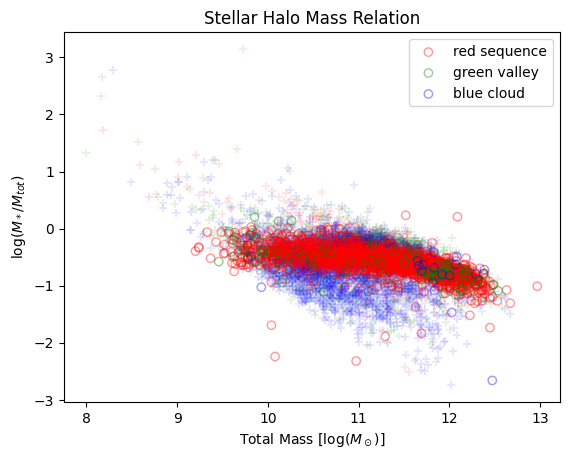

In [26]:
plt.scatter(spirals[spirals['CMD_class']==3]['M_R90'], 
            spirals[spirals['CMD_class']==3]['M90_disk']-spirals[spirals['CMD_class']==3]['M_R90'],
            alpha=0.1, color='r', marker='+')
plt.scatter(spirals[spirals['CMD_class']==2]['M_R90'], 
            spirals[spirals['CMD_class']==2]['M90_disk']-spirals[spirals['CMD_class']==2]['M_R90'],
            alpha=0.1, color='g', marker='+')
plt.scatter(spirals[spirals['CMD_class']==1]['M_R90'], 
            spirals[spirals['CMD_class']==1]['M90_disk']-spirals[spirals['CMD_class']==1]['M_R90'],
            alpha=0.1, color='b', marker='+')


plt.scatter(Mvir[ellipticals['CMD_class'] == 3], Mstar[ellipticals['CMD_class'] == 3]-Mvir[ellipticals['CMD_class'] == 3],
            alpha=0.4, color = 'r', label='red sequence', facecolor='none')
            
plt.scatter(Mvir[ellipticals['CMD_class'] == 2], Mstar[ellipticals['CMD_class'] == 2]-Mvir[ellipticals['CMD_class'] == 2],
            alpha=0.4, color = 'g', label='green valley', facecolor='none')
            
plt.scatter(Mvir[ellipticals['CMD_class'] == 1], Mstar[ellipticals['CMD_class'] == 1]-Mvir[ellipticals['CMD_class'] == 1],
            alpha=0.4, color = 'b', label='blue cloud', facecolor='none')

            
plt.legend()
plt.ylabel(r'$\log(M_*/M_{tot})$')
plt.xlabel(r'Total Mass [$\log (M_\odot)$]')
#plt.plot([9,13],[9,13],color='k',alpha=0.2)
plt.title('Stellar Halo Mass Relation')
#plt.savefig(plot_dir + 'SHMR_all_morph.png')
plt.show()

## scatter plots with medians

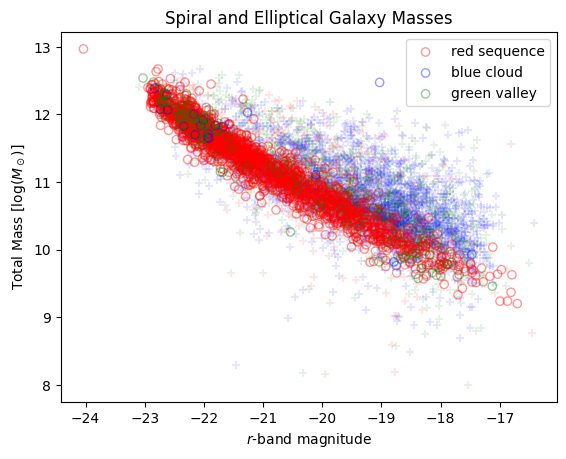

In [27]:
plt.scatter(s_mag[spirals['CMD_class'] == 1], spirals['M_R90'][spirals['CMD_class'] == 1], color='b', alpha=0.1, marker='+')
plt.scatter(s_mag[spirals['CMD_class'] == 2], spirals['M_R90'][spirals['CMD_class'] == 2], color='g', alpha=0.1,marker='+')
plt.scatter(s_mag[spirals['CMD_class'] == 3], spirals['M_R90'][spirals['CMD_class'] == 3], color='r', alpha=0.1,marker='+')
plt.scatter(e_mag[ellipticals['CMD_class'] == 3], Mvir[ellipticals['CMD_class'] == 3], 
            color='r', alpha=0.4, label='red sequence', facecolor='none')
plt.scatter(e_mag[ellipticals['CMD_class'] == 1], Mvir[ellipticals['CMD_class'] == 1], 
            color='b', alpha=0.4, label='blue cloud', facecolor='none')
plt.scatter(e_mag[ellipticals['CMD_class'] == 2], Mvir[ellipticals['CMD_class'] == 2], 
            color='g', alpha=0.4, label='green valley', facecolor='none')


plt.legend()
plt.xlabel('$r$-band magnitude')
plt.ylabel(r'Total Mass [$\log(M_\odot)$]')
plt.title('Spiral and Elliptical Galaxy Masses')
#plt.xlim(-16.8,-22.9)
#plt.ylim(9.5,12.6)
#plt.savefig(plot_dir + 'mag_totmass_allmorph_zoom.png')
plt.show()

In [28]:
magnitude_bins = np.linspace(np.min(e_mag),np.max(s_mag),15)
points = (magnitude_bins[1:] + magnitude_bins[:-1])/2
s_med = np.zeros(len(points))
e_med = np.zeros(len(points))
s_err = np.zeros(len(points)) # uncertainty def as RMS/sqrt(N)
e_err = np.zeros(len(points)) 


for i in range(len(points)):
    mag_lim = magnitude_bins[i+1]
    if i == 0:
        e_vals = Mvir[e_mag <= mag_lim]
        s_vals = spirals['M_R90'][s_mag <= mag_lim]

    else:
        lower_lim = magnitude_bins[i]
        e_vals = Mvir[np.logical_and(e_mag <= mag_lim, e_mag > lower_lim)]
        s_vals = spirals['M_R90'][np.logical_and(s_mag <= mag_lim, s_mag > lower_lim)]

    e_med[i] = np.median(e_vals)
    s_med[i] = np.median(s_vals)
    e_err[i] = np.sqrt(np.mean((10**e_vals)**2)/len(e_vals))
    s_err[i] = np.sqrt(np.mean((10**s_vals)**2)/len(s_vals))


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/var/folders/4q/zk1xkb454t7_ncsh3pf51p700000gp/T/ipykernel_56178/3773142508.py:21: UserWarning: Warning: converting a masked element to nan.
  s_med[i] = np.median(s_vals)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:5334: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [29]:
e_err_bars = np.zeros((2,len(points)))
s_err_bars = np.zeros((2,len(points)))

for i in range(len(points)):
    e_err_bars[0][i] = e_med[i]-np.log10(10**e_med[i] - e_err[i])
    e_err_bars[1][i] = np.log10(10**e_med[i] + e_err[i]) - e_med[i]
    s_err_bars[0][i] = s_med[i]-np.log10(10**s_med[i] - s_err[i])
    s_err_bars[1][i] = np.log10(10**s_med[i] + s_err[i]) - s_med[i]

/var/folders/4q/zk1xkb454t7_ncsh3pf51p700000gp/T/ipykernel_56178/2405311389.py:5: RuntimeWarning: divide by zero encountered in log10
  e_err_bars[0][i] = e_med[i]-np.log10(10**e_med[i] - e_err[i])
/var/folders/4q/zk1xkb454t7_ncsh3pf51p700000gp/T/ipykernel_56178/2405311389.py:7: RuntimeWarning: divide by zero encountered in log10
  s_err_bars[0][i] = s_med[i]-np.log10(10**s_med[i] - s_err[i])
/var/folders/4q/zk1xkb454t7_ncsh3pf51p700000gp/T/ipykernel_56178/2405311389.py:5: RuntimeWarning: invalid value encountered in log10
  e_err_bars[0][i] = e_med[i]-np.log10(10**e_med[i] - e_err[i])
/var/folders/4q/zk1xkb454t7_ncsh3pf51p700000gp/T/ipykernel_56178/2405311389.py:7: RuntimeWarning: invalid value encountered in log10
  s_err_bars[0][i] = s_med[i]-np.log10(10**s_med[i] - s_err[i])


In [30]:
s_err_bars

array([[       nan,        inf, 0.17147203, 0.061338  , 0.04939287,
        0.05327778, 0.0475749 , 0.04926756, 0.05189451, 0.05172206,
        0.06069748, 0.11127093, 0.22153559,        nan],
       [       nan, 0.30103   , 0.12261057, 0.0537373 , 0.04434461,
        0.04745024, 0.04287402, 0.04424361, 0.04635017, 0.04621259,
        0.05324523, 0.08849797, 0.14599375, 0.80038814]])

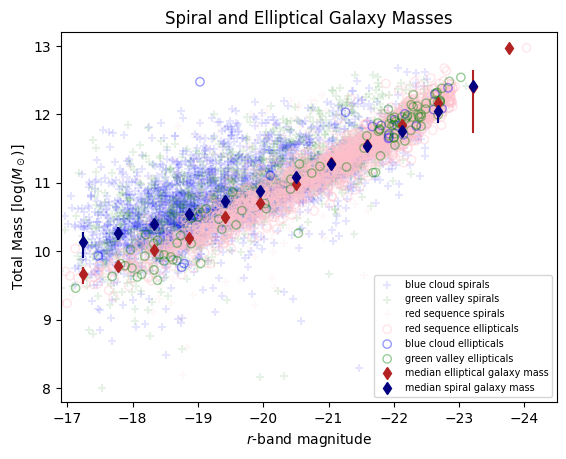

In [34]:
plt.scatter(s_mag[spirals['CMD_class'] == 1], spirals['M_R90'][spirals['CMD_class'] == 1], 
            color='blue', alpha=0.1, marker='+', label='blue cloud spirals')
plt.scatter(s_mag[spirals['CMD_class'] == 2], spirals['M_R90'][spirals['CMD_class'] == 2], 
            color='g', alpha=0.1,marker='+', label='green valley spirals')
plt.scatter(s_mag[spirals['CMD_class'] == 3], spirals['M_R90'][spirals['CMD_class'] == 3], 
            color='pink', alpha=0.1,marker='+', label='red sequence spirals')
plt.scatter(e_mag[ellipticals['CMD_class'] == 3], Mvir[ellipticals['CMD_class'] == 3], 
            color='pink', alpha=0.4, label='red sequence ellipticals', facecolor='none')
plt.scatter(e_mag[ellipticals['CMD_class'] == 1], Mvir[ellipticals['CMD_class'] == 1], 
            color='b', alpha=0.4, label='blue cloud ellipticals', facecolor='none')
plt.scatter(e_mag[ellipticals['CMD_class'] == 2], Mvir[ellipticals['CMD_class'] == 2], 
            color='g', alpha=0.4, label='green valley ellipticals', facecolor='none')

# plt.scatter(points[:-1], e_med[:-1], color='firebrick', 
#              marker='d', label='median elliptical galaxy mass', )
# plt.scatter(points[:-1], s_med[:-1], color='navy',
#              marker='d', label='median spiral galaxy mass',)

plt.errorbar(points, e_med, color='firebrick', yerr=e_err_bars, 
             marker='d', label='median elliptical galaxy mass', linestyle='none')
plt.errorbar(points, s_med, color='navy', yerr=s_err_bars, 
             marker='d', label='median spiral galaxy mass',linestyle='none')

plt.legend(fontsize='x-small')
plt.xlabel('$r$-band magnitude')
plt.ylabel(r'Total Mass [$\log(M_\odot)$]')
plt.title('Spiral and Elliptical Galaxy Masses')
plt.xlim(-16.9,-24.5)
#plt.xlim(-16.8,-22.9)
plt.ylim(7.8,13.2)
plt.savefig(plot_dir + 'med_mag_totmass_allmorph_err.png')
plt.show()

## void vs wall galaxies

vflag 1 = void, 0 = wall

In [35]:
s_void_mask = spirals['vflag_VF'] == 1
e_void_mask = ellipticals['vflag_VF'] == 1
s_wall_mask = spirals['vflag_VF'] == 0
e_wall_mask = ellipticals['vflag_VF'] == 0

s_void = spirals[s_void_mask]
s_mag_void = s_mag[s_void_mask]

e_void = ellipticals[e_void_mask]
e_mag_void = e_mag[e_void_mask]

s_wall = spirals[s_wall_mask]
s_mag_wall = s_mag[s_wall_mask]

e_wall = ellipticals[e_wall_mask]
e_mag_wall = e_mag[e_wall_mask]


In [36]:
s_void_med = np.zeros(len(points))
e_void_med = np.zeros(len(points))
s_wall_med = np.zeros(len(points))
e_wall_med = np.zeros(len(points))

s_void_med_err = np.zeros(len(points))
e_void_med_err = np.zeros(len(points))
s_wall_med_err = np.zeros(len(points))
e_wall_med_err = np.zeros(len(points))

for i in range(len(points)):
    mag_lim = magnitude_bins[i+1]
    if i == 0:
        s_void_med_vals = s_void['M_R90'][s_mag_void <= mag_lim]
        e_void_med_vals = e_void['Mvir'][e_mag_void <= mag_lim]
        s_wall_med_vals = s_wall['M_R90'][s_mag_wall <= mag_lim]
        e_wall_med_vals = e_wall['Mvir'][e_mag_wall <= mag_lim]
    else:
        lower_lim = magnitude_bins[i]

        s_void_med_vals = s_void['M_R90'][np.logical_and(s_mag_void <= mag_lim, s_mag_void > lower_lim)]
        e_void_med_vals = e_void['Mvir'][np.logical_and(e_mag_void <= mag_lim, e_mag_void > lower_lim)]
        s_wall_med_vals = s_wall['M_R90'][np.logical_and(s_mag_wall <= mag_lim, s_mag_wall > lower_lim)]
        e_wall_med_vals = e_wall['Mvir'][np.logical_and(e_mag_wall <= mag_lim, e_mag_wall > lower_lim)]


    s_void_med[i] = ma.median(s_void_med_vals)
    e_void_med[i] = ma.median(e_void_med_vals)
    s_wall_med[i] = ma.median(s_wall_med_vals)
    e_wall_med[i] = ma.median(e_wall_med_vals)

    s_void_med_err[i] = ma.sqrt(ma.mean((10**s_void_med_vals)**2)/len(s_void_med_vals))
    e_void_med_err[i] = ma.sqrt(ma.mean((10**e_void_med_vals)**2)/len(e_void_med_vals))
    s_wall_med_err[i] = ma.sqrt(ma.mean((10**s_wall_med_vals)**2)/len(s_wall_med_vals))
    e_wall_med_err[i] = ma.sqrt(ma.mean((10**e_wall_med_vals)**2)/len(e_wall_med_vals))
    

/var/folders/4q/zk1xkb454t7_ncsh3pf51p700000gp/T/ipykernel_56178/406428692.py:27: UserWarning: Warning: converting a masked element to nan.
  s_void_med[i] = ma.median(s_void_med_vals)
/var/folders/4q/zk1xkb454t7_ncsh3pf51p700000gp/T/ipykernel_56178/406428692.py:28: UserWarning: Warning: converting a masked element to nan.
  e_void_med[i] = ma.median(e_void_med_vals)
/var/folders/4q/zk1xkb454t7_ncsh3pf51p700000gp/T/ipykernel_56178/406428692.py:29: UserWarning: Warning: converting a masked element to nan.
  s_wall_med[i] = ma.median(s_wall_med_vals)
/var/folders/4q/zk1xkb454t7_ncsh3pf51p700000gp/T/ipykernel_56178/406428692.py:30: UserWarning: Warning: converting a masked element to nan.
  e_wall_med[i] = ma.median(e_wall_med_vals)
/var/folders/4q/zk1xkb454t7_ncsh3pf51p700000gp/T/ipykernel_56178/406428692.py:32: UserWarning: Warning: converting a masked element to nan.
  s_void_med_err[i] = ma.sqrt(ma.mean((10**s_void_med_vals)**2)/len(s_void_med_vals))
/var/folders/4q/zk1xkb454t7_ncsh3p

In [37]:
s_void_err = np.zeros((2,len(points)))
e_void_err = np.zeros((2,len(points)))
s_wall_err = np.zeros((2,len(points)))
e_wall_err = np.zeros((2,len(points)))

for i in range(len(points)):

    s_void_err[0][i] = s_void_med[i]-np.log10(10**s_void_med[i] - s_void_med_err[i])
    s_void_err[1][i] = np.log10(10**s_void_med[i] + s_void_med_err[i])-s_void_med[i]

    e_void_err[0][i] = e_void_med[i]-np.log10(10**e_void_med[i] - e_void_med_err[i])
    e_void_err[1][i] = np.log10(10**e_void_med[i] + e_void_med_err[i])-e_void_med[i]

    s_wall_err[0][i] = s_wall_med[i]-np.log10(10**s_wall_med[i] - s_wall_med_err[i])
    s_wall_err[1][i] = np.log10(10**s_wall_med[i] + s_wall_med_err[i])-s_wall_med[i]

    e_wall_err[0][i] = e_wall_med[i]-np.log10(10**e_wall_med[i] - e_wall_med_err[i])
    e_wall_err[1][i] = np.log10(10**e_wall_med[i] + e_wall_med_err[i])-e_wall_med[i]
    

/var/folders/4q/zk1xkb454t7_ncsh3pf51p700000gp/T/ipykernel_56178/1283907380.py:8: RuntimeWarning: divide by zero encountered in log10
  s_void_err[0][i] = s_void_med[i]-np.log10(10**s_void_med[i] - s_void_med_err[i])
/var/folders/4q/zk1xkb454t7_ncsh3pf51p700000gp/T/ipykernel_56178/1283907380.py:11: RuntimeWarning: divide by zero encountered in log10
  e_void_err[0][i] = e_void_med[i]-np.log10(10**e_void_med[i] - e_void_med_err[i])
/var/folders/4q/zk1xkb454t7_ncsh3pf51p700000gp/T/ipykernel_56178/1283907380.py:11: RuntimeWarning: invalid value encountered in log10
  e_void_err[0][i] = e_void_med[i]-np.log10(10**e_void_med[i] - e_void_med_err[i])
/var/folders/4q/zk1xkb454t7_ncsh3pf51p700000gp/T/ipykernel_56178/1283907380.py:8: RuntimeWarning: invalid value encountered in log10
  s_void_err[0][i] = s_void_med[i]-np.log10(10**s_void_med[i] - s_void_med_err[i])
/var/folders/4q/zk1xkb454t7_ncsh3pf51p700000gp/T/ipykernel_56178/1283907380.py:14: RuntimeWarning: divide by zero encountered in log

In [38]:
e_wall_err

array([[       nan,        nan, 0.05292006, 0.03228678, 0.03350439,
        0.03840977, 0.05673815, 0.0616297 , 0.05819083, 0.067864  ,
        0.09025835, 0.11851789, 0.15577909, 0.89239822],
       [       nan,        nan, 0.04716636, 0.03005168, 0.03110373,
        0.03528705, 0.05017484, 0.05396097, 0.05130714, 0.05867859,
        0.07468952, 0.09301144, 0.11441492, 0.27227904]])

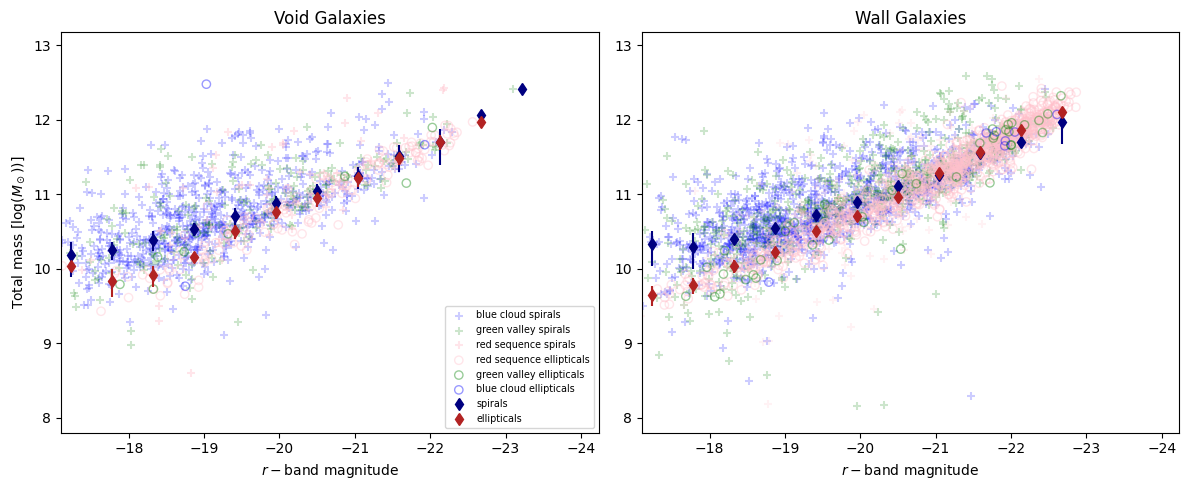

In [39]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

#labels

ax[0].set_title('Void Galaxies')
ax[1].set_title('Wall Galaxies')
#ax[0].set_xlim(magnitude_bins[-1]+0.2, magnitude_bins[0]-0.2)
#ax[1].set_xlim(magnitude_bins[-1]+0.2, magnitude_bins[0]-0.2)

ax[0].set_xlim(-17.1, magnitude_bins[0]-0.2)
ax[1].set_xlim(-17.1, magnitude_bins[0]-0.2)


ax[0].set_ylabel(r'Total mass [$\log(M_\odot))$]')
ax[0].set_xlabel('$r-$band magnitude')
ax[1].set_xlabel('$r-$band magnitude')
ax[0].set_ylim(np.min(spirals['M_R90'])-0.2,np.max(Mvir)+0.2)
ax[1].set_ylim(np.min(spirals['M_R90'])-0.2,np.max(Mvir)+0.2)


#void data
ax[0].scatter(s_mag_void[s_void['CMD_class'] == 1],s_void[s_void['CMD_class'] == 1]['M_R90'],
              color='b', alpha=0.2, marker='+', label='blue cloud spirals')
ax[0].scatter(s_mag_void[s_void['CMD_class'] == 2],s_void[s_void['CMD_class'] == 2]['M_R90'],
              color='g', alpha=0.2, marker='+', label='green valley spirals')
ax[0].scatter(s_mag_void[s_void['CMD_class'] == 3],s_void[s_void['CMD_class'] == 3]['M_R90'],
              color='pink', alpha=0.4, marker='+', label='red sequence spirals')

ax[0].scatter(e_mag_void[e_void['CMD_class'] == 3],e_void[e_void['CMD_class'] == 3]['Mvir'],
              color='pink', alpha=0.4, marker='o', label='red sequence ellipticals', facecolor='none')
ax[0].scatter(e_mag_void[e_void['CMD_class'] == 2],e_void[e_void['CMD_class'] == 2]['Mvir'],
              color='g', alpha=0.4, marker='o', label='green valley ellipticals', facecolor='none')
ax[0].scatter(e_mag_void[e_void['CMD_class'] == 1],e_void[e_void['CMD_class'] == 1]['Mvir'],
              color='b', alpha=0.4, marker='o', label='blue cloud ellipticals', facecolor='none')

#wall data
ax[1].scatter(s_mag_wall[s_wall['CMD_class'] == 1],s_wall[s_wall['CMD_class'] == 1]['M_R90'],
              color='b', alpha=0.2, marker='+')
ax[1].scatter(s_mag_wall[s_wall['CMD_class'] == 2],s_wall[s_wall['CMD_class'] == 2]['M_R90'],
              color='g', alpha=0.2, marker='+')
ax[1].scatter(s_mag_wall[s_wall['CMD_class'] == 3],s_wall[s_wall['CMD_class'] == 3]['M_R90'],
              color='pink', alpha=0.2, marker='+')

ax[1].scatter(e_mag_wall[e_wall['CMD_class'] == 3],e_wall[e_wall['CMD_class'] == 3]['Mvir'],
              color='pink', alpha=0.4, marker='o', label='red sequence', facecolor='none')
ax[1].scatter(e_mag_wall[e_wall['CMD_class'] == 2],e_wall[e_wall['CMD_class'] == 2]['Mvir'],
              color='g', alpha=0.4, marker='o', label='green valley', facecolor='none')
ax[1].scatter(e_mag_wall[e_wall['CMD_class'] == 1],e_wall[e_wall['CMD_class'] == 1]['Mvir'],
              color='b', alpha=0.4, marker='o', label='blue cloud', facecolor='none')



#medians
# ax[0].scatter(points[:-1], s_void_med[:-1], color='navy', marker='d', label='spirals')
# ax[0].scatter(points,e_void_med, color='firebrick', marker='d', label='ellipticals')
# ax[1].scatter(points[:-1], s_wall_med[:-1], color='navy', marker='d')
# ax[1].scatter(points[:-1],e_wall_med[:-1], color='firebrick', marker='d')

ax[0].errorbar(points, s_void_med, color='navy', yerr=s_void_err,
               marker='d', label='spirals', linestyle='none')
ax[0].errorbar(points,e_void_med, color='firebrick', yerr=e_void_err,
               marker='d', label='ellipticals',linestyle='none')
ax[1].errorbar(points, s_wall_med, yerr=s_wall_err,
               color='navy', marker='d',linestyle='none')
ax[1].errorbar(points,e_wall_med, yerr=e_wall_err,
               color='firebrick', marker='d',linestyle='none')

ax[0].legend(fontsize='x-small')

fig.tight_layout()
fig.savefig(plot_dir + 'void_wall_all_err.png', )


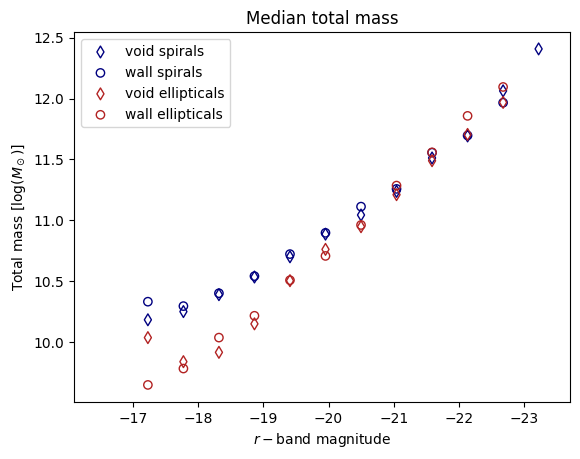

In [128]:
plt.scatter(points[:-1], s_void_med[:-1], color='navy', marker='d', label='void spirals', facecolor='none')
plt.scatter(points[:-1], s_wall_med[:-1], color='navy', marker='o', label='wall spirals',facecolor='none')
plt.scatter(points, e_void_med, color = 'firebrick', marker='d', label='void ellipticals', facecolor='none')
plt.scatter(points[:-1], e_wall_med[:-1], color='firebrick', marker='o', label='wall ellipticals',facecolor='none')


# plt.errorbar(points, s_void_med, yerr=s_void_err, color='navy', marker='d', label='void spirals', linestyle='none',markerfacecolor='none')
# plt.errorbar(points, s_wall_med, yerr=s_wall_err, color='navy', marker='o', label='wall spirals',linestyle='none',markerfacecolor='none')
# plt.errorbar(points, e_void_med, yerr=e_void_err, color = 'firebrick', marker='d', label='void ellipticals',linestyle='none',markerfacecolor='none')
# plt.errorbar(points, e_wall_med, yerr=e_wall_err, color='firebrick', marker='o', label='wall ellipticals',linestyle='none',markerfacecolor='none')

plt.title('Median total mass')
plt.xlabel('$r-$band magnitude')
plt.ylabel(r'Total mass [$\log(M_\odot)$]')
#plt.yscale('log')
plt.legend()
plt.xlim(-16.1, -23.7)
#plt.savefig(plot_dir + 'med_tot_mass_env_err.png')
plt.savefig(plot_dir + 'med_tot_mass_env.png')
plt.show()

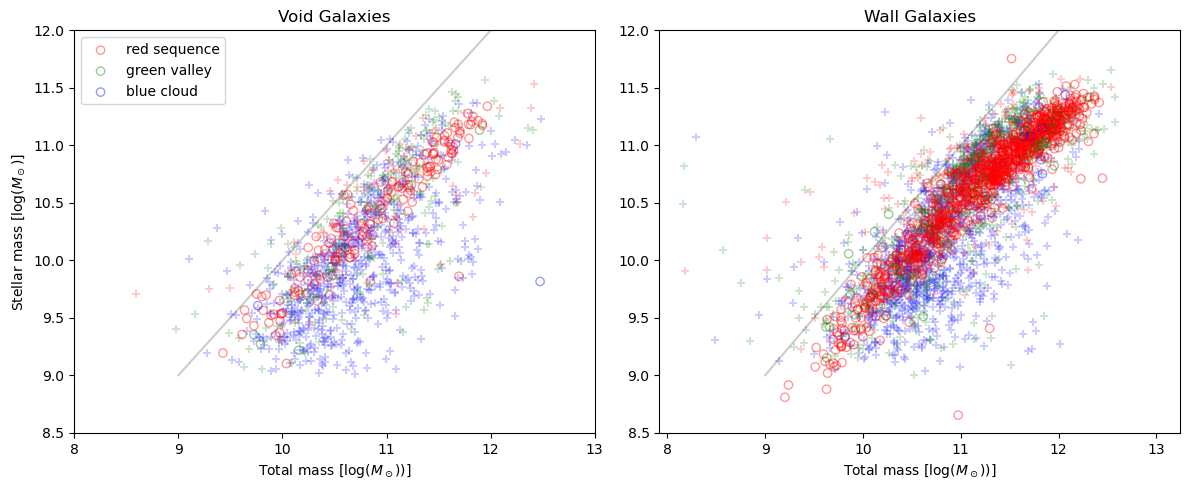

In [170]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

#labels

ax[0].set_title('Void Galaxies')
ax[1].set_title('Wall Galaxies')
#ax[0].set_xlim(magnitude_bins[-1]+0.2, magnitude_bins[0]-0.2)
#ax[1].set_xlim(magnitude_bins[-1]+0.2, magnitude_bins[0]-0.2)
ax[0].set_xlabel(r'Total mass [$\log(M_\odot))$]')
ax[1].set_xlabel(r'Total mass [$\log(M_\odot))$]')
ax[0].set_ylabel(r'Stellar mass [$\log(M_\odot)]$')
#ax[0].set_ylim(np.min(spirals['M_R90'])-0.2,np.max(Mvir)+0.2)
#ax[1].set_ylim(np.min(spirals['M_R90'])-0.2,np.max(Mvir)+0.2)
ax[0].set_ylim(8.5,12)
ax[1].set_ylim(8.5,12)
ax[0].set_xlim(8,13)

ax[0].plot([9,13],[9,13],color='k',alpha=0.2)
ax[1].plot([9,13],[9,13],color='k',alpha=0.2)

#void
ax[0].scatter(s_void[s_void['CMD_class'] == 1]['M_R90'],s_void[s_void['CMD_class'] == 1]['M90_disk'],
              color='b', alpha=0.2, marker='+')
ax[0].scatter(s_void[s_void['CMD_class'] == 2]['M_R90'],s_void[s_void['CMD_class'] == 2]['M90_disk'],
              color='g', alpha=0.2, marker='+')
ax[0].scatter(s_void[s_void['CMD_class'] == 3]['M_R90'],s_void[s_void['CMD_class'] == 3]['M90_disk'],
              color='r', alpha=0.2, marker='+')

ax[0].scatter(e_void[e_void['CMD_class'] == 3]['Mvir'],np.log10(e_void[e_void['CMD_class'] == 3]['nsa_sersic_mass']),
              color='r', alpha=0.4, marker='o', label='red sequence', facecolor='none')
ax[0].scatter(e_void[e_void['CMD_class'] == 2]['Mvir'],np.log10(e_void[e_void['CMD_class'] == 2]['nsa_sersic_mass']),
              color='g', alpha=0.4, marker='o', label='green valley', facecolor='none')
ax[0].scatter(e_void[e_void['CMD_class'] == 1]['Mvir'],np.log10(e_void[e_void['CMD_class'] == 1]['nsa_sersic_mass']),
              color='b', alpha=0.4, marker='o', label='blue cloud', facecolor='none')

ax[0].legend()

#wall
ax[1].scatter(s_wall[s_wall['CMD_class'] == 1]['M_R90'],s_wall[s_wall['CMD_class'] == 1]['M90_disk'],
              color='b', alpha=0.2, marker='+')
ax[1].scatter(s_wall[s_wall['CMD_class'] == 2]['M_R90'],s_wall[s_wall['CMD_class'] == 2]['M90_disk'],
              color='g', alpha=0.2, marker='+')
ax[1].scatter(s_wall[s_wall['CMD_class'] == 3]['M_R90'],s_wall[s_wall['CMD_class'] == 3]['M90_disk'],
              color='r', alpha=0.2, marker='+')

ax[1].scatter(e_wall[e_wall['CMD_class'] == 3]['Mvir'],np.log10(e_wall[e_wall['CMD_class'] == 3]['nsa_sersic_mass']),
              color='r', alpha=0.4, marker='o', label='red sequence', facecolor='none')
ax[1].scatter(e_wall[e_wall['CMD_class'] == 2]['Mvir'],np.log10(e_wall[e_wall['CMD_class'] == 2]['nsa_sersic_mass']),
              color='g', alpha=0.4, marker='o', label='green valley', facecolor='none')
ax[1].scatter(e_wall[e_wall['CMD_class'] == 1]['Mvir'],np.log10(e_wall[e_wall['CMD_class'] == 1]['nsa_sersic_mass']),
              color='b', alpha=0.4, marker='o', label='blue cloud', facecolor='none')

fig.tight_layout()
fig.savefig(plot_dir + 'env_stellar_total_mass.png')

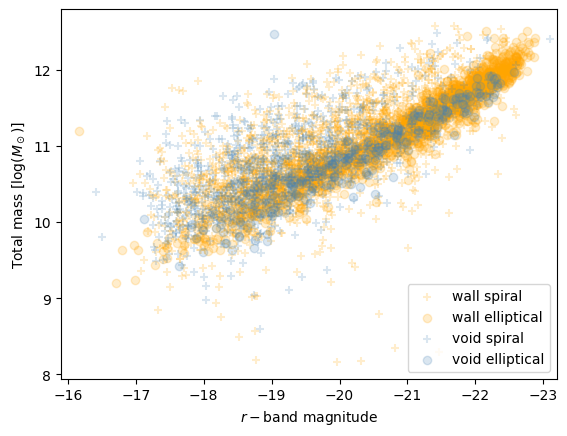

In [135]:
# distribution of all void and wall galaxies

plt.scatter(s_mag_wall,s_wall['M_R90'], color='orange', alpha=0.2, marker='+', label='wall spiral')
plt.scatter(e_mag_wall,e_wall['Mvir'], color='orange', alpha=0.2, marker='o', label='wall elliptical')
plt.scatter(s_mag_void,s_void['M_R90'], color='steelblue', alpha=0.2, marker='+', label='void spiral')
plt.scatter(e_mag_void,e_void['Mvir'], color='steelblue', alpha=0.2, marker='o', label='void elliptical')
plt.xlim(-15.9, -23.2)
plt.xlabel('$r-$band magnitude')
plt.ylabel(r'Total mass [$\log(M_\odot)$]')
plt.legend()
plt.savefig(plot_dir + 'all_void_wall.png')
plt.show()

## Mvis vs. Mtot plots

In [137]:
spirals_HI_R90 = spirals[spirals['logHI_R90']>0]
spirals_HI = spirals[spirals['logHI']>0]
ellipticals_HI = ellipticals[ellipticals['logHI']>0]
ellipticals_HI_lim = ellipticals[ellipticals['logHIlim']>0]

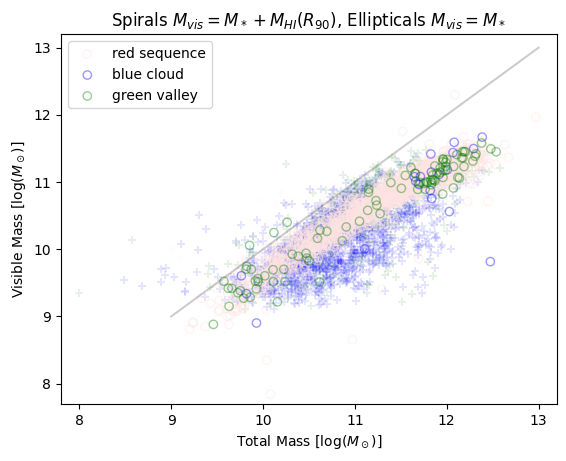

In [174]:
plt.scatter(spirals_HI_R90[spirals_HI_R90['CMD_class']==3]['M_R90'],
            np.log10(10**spirals_HI_R90[spirals_HI_R90['CMD_class']==3]['M90_disk']+10**spirals_HI_R90[spirals_HI_R90['CMD_class']==3]['logHI_R90']),
            alpha=0.1, color='mistyrose', marker='+')

plt.scatter(spirals_HI_R90[spirals_HI_R90['CMD_class']==2]['M_R90'],
            np.log10(10**spirals_HI_R90[spirals_HI_R90['CMD_class']==2]['M90_disk']+10**spirals_HI_R90[spirals_HI_R90['CMD_class']==2]['logHI_R90']),
            alpha=0.1, color='g', marker='+')

plt.scatter(spirals_HI_R90[spirals_HI_R90['CMD_class']==1]['M_R90'],
            np.log10(10**spirals_HI_R90[spirals_HI_R90['CMD_class']==1]['M90_disk']+10**spirals_HI_R90[spirals_HI_R90['CMD_class']==1]['logHI_R90']),
            alpha=0.1, color='b', marker='+')


plt.scatter(Mvir[ellipticals['CMD_class'] == 3], Mstar[ellipticals['CMD_class'] == 3],
            alpha=0.4, color = 'mistyrose', label='red sequence', facecolor='none')
plt.scatter(Mvir[ellipticals['CMD_class'] == 1], Mstar[ellipticals['CMD_class'] == 1],
            color = 'b', alpha=0.4, label='blue cloud', facecolor='none')
plt.scatter(Mvir[ellipticals['CMD_class'] == 2], Mstar[ellipticals['CMD_class'] == 2],
            alpha=0.4, color = 'g', label='green valley', facecolor='none')
plt.legend()
plt.xlabel(r'Total Mass [$\log (M_\odot)$]')
plt.ylabel(r'Visible Mass [$\log (M_\odot)$]')
plt.plot([9,13],[9,13],color='k',alpha=0.2)
plt.title(r'Spirals $M_{vis} = M_* + M_{HI}(R_{90})$, Ellipticals $M_{vis}=M_*$')
plt.ylim(7.7,13.2)
plt.xlim(7.8,13.2)
plt.savefig(plot_dir + 'Mvis1.png')
plt.show()

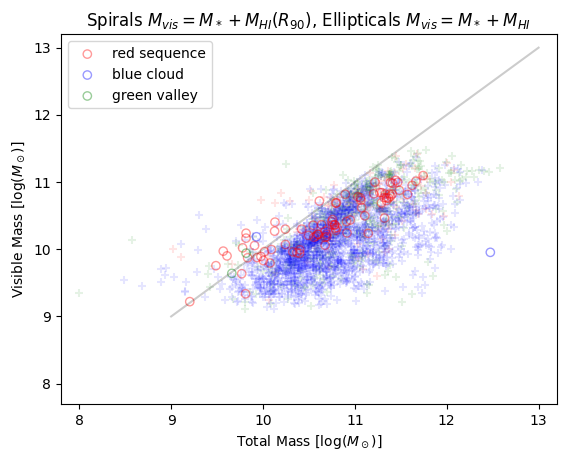

In [175]:
plt.scatter(spirals_HI_R90[spirals_HI_R90['CMD_class']==3]['M_R90'],
            np.log10(10**spirals_HI_R90[spirals_HI_R90['CMD_class']==3]['M90_disk']+10**spirals_HI_R90[spirals_HI_R90['CMD_class']==3]['logHI_R90']),
            alpha=0.1, color='r', marker='+')

plt.scatter(spirals_HI_R90[spirals_HI_R90['CMD_class']==2]['M_R90'],
            np.log10(10**spirals_HI_R90[spirals_HI_R90['CMD_class']==2]['M90_disk']+10**spirals_HI_R90[spirals_HI_R90['CMD_class']==2]['logHI_R90']),
            alpha=0.1, color='g', marker='+')

plt.scatter(spirals_HI_R90[spirals_HI_R90['CMD_class']==1]['M_R90'],
            np.log10(10**spirals_HI_R90[spirals_HI_R90['CMD_class']==1]['M90_disk']+10**spirals_HI_R90[spirals_HI_R90['CMD_class']==1]['logHI_R90']),
            alpha=0.1, color='b', marker='+')


plt.scatter(ellipticals_HI[ellipticals_HI['CMD_class'] == 3]['Mvir'], 
            np.log10(ellipticals_HI[ellipticals_HI['CMD_class'] == 3]['nsa_sersic_mass']+10**ellipticals_HI[ellipticals_HI['CMD_class'] == 3]['logHI']),
            alpha=0.4, color = 'r', label='red sequence', facecolor='none')
plt.scatter(ellipticals_HI[ellipticals_HI['CMD_class'] == 1]['Mvir'], 
            np.log10(ellipticals_HI[ellipticals_HI['CMD_class'] == 1]['nsa_sersic_mass']+10**ellipticals_HI[ellipticals_HI['CMD_class'] == 1]['logHI']),
            color = 'b', alpha=0.4, label='blue cloud', facecolor='none')
plt.scatter(ellipticals_HI[ellipticals_HI['CMD_class'] == 2]['Mvir'], 
            np.log10(ellipticals_HI[ellipticals_HI['CMD_class'] == 2]['nsa_sersic_mass']+10**ellipticals_HI[ellipticals_HI['CMD_class'] == 2]['logHI']),
            alpha=0.4, color = 'g', label='green valley', facecolor='none')
plt.legend()
plt.xlabel(r'Total Mass [$\log (M_\odot)$]')
plt.ylabel(r'Visible Mass [$\log (M_\odot)$]')
plt.plot([9,13],[9,13],color='k',alpha=0.2)
plt.ylim(7.7,13.2)
plt.xlim(7.8,13.2)
plt.title(r'Spirals $M_{vis} = M_* + M_{HI}(R_{90})$, Ellipticals $M_{vis}=M_* + M_{HI}$')
plt.savefig(plot_dir + 'Mvis2.png')
plt.show()

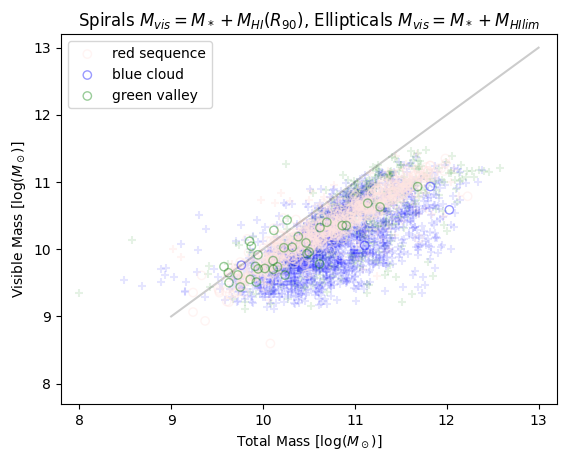

In [176]:
plt.scatter(spirals_HI_R90[spirals_HI_R90['CMD_class']==3]['M_R90'],
            np.log10(10**spirals_HI_R90[spirals_HI_R90['CMD_class']==3]['M90_disk']+10**spirals_HI_R90[spirals_HI_R90['CMD_class']==3]['logHI_R90']),
            alpha=0.4, color='mistyrose', marker='+')

plt.scatter(spirals_HI_R90[spirals_HI_R90['CMD_class']==2]['M_R90'],
            np.log10(10**spirals_HI_R90[spirals_HI_R90['CMD_class']==2]['M90_disk']+10**spirals_HI_R90[spirals_HI_R90['CMD_class']==2]['logHI_R90']),
            alpha=0.1, color='g', marker='+')

plt.scatter(spirals_HI_R90[spirals_HI_R90['CMD_class']==1]['M_R90'],
            np.log10(10**spirals_HI_R90[spirals_HI_R90['CMD_class']==1]['M90_disk']+10**spirals_HI_R90[spirals_HI_R90['CMD_class']==1]['logHI_R90']),
            alpha=0.1, color='b', marker='+')


plt.scatter(ellipticals_HI_lim[ellipticals_HI_lim['CMD_class'] == 3]['Mvir'], 
            np.log10(ellipticals_HI_lim[ellipticals_HI_lim['CMD_class'] == 3]['nsa_sersic_mass']+
                     10**ellipticals_HI_lim[ellipticals_HI_lim['CMD_class'] == 3]['logHIlim']),
            alpha=0.4, color = 'mistyrose', label='red sequence', facecolor='none')
plt.scatter(ellipticals_HI_lim[ellipticals_HI_lim['CMD_class'] == 1]['Mvir'], 
            np.log10(ellipticals_HI_lim[ellipticals_HI_lim['CMD_class'] == 1]['nsa_sersic_mass']+
                     10**ellipticals_HI_lim[ellipticals_HI_lim['CMD_class'] == 1]['logHIlim']),
            color = 'b', alpha=0.4, label='blue cloud', facecolor='none')
plt.scatter(ellipticals_HI_lim[ellipticals_HI_lim['CMD_class'] == 2]['Mvir'], 
            np.log10(ellipticals_HI_lim[ellipticals_HI_lim['CMD_class'] == 2]['nsa_sersic_mass']+
                     10**ellipticals_HI_lim[ellipticals_HI_lim['CMD_class'] == 2]['logHIlim']),
            alpha=0.4, color = 'g', label='green valley', facecolor='none')
plt.legend()
plt.xlabel(r'Total Mass [$\log (M_\odot)$]')
plt.ylabel(r'Visible Mass [$\log (M_\odot)$]')
plt.plot([9,13],[9,13],color='k',alpha=0.2)
plt.ylim(7.7,13.2)
plt.xlim(7.8,13.2)
plt.title(r'Spirals $M_{vis} = M_* + M_{HI}(R_{90})$, Ellipticals $M_{vis}=M_* + M_{HIlim}$')
plt.savefig(plot_dir + 'Mvis3.png')
plt.show()

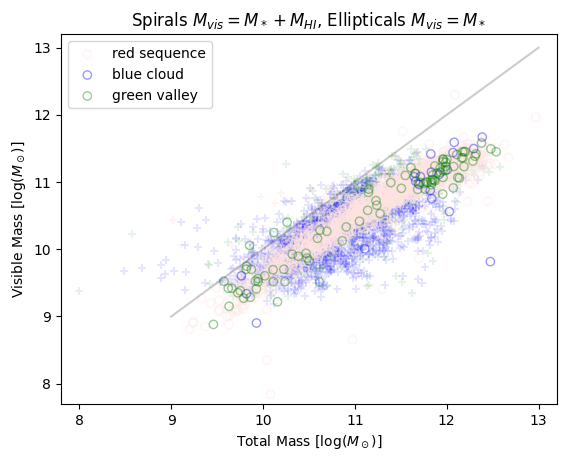

In [177]:
plt.scatter(spirals_HI[spirals_HI['CMD_class']==3]['M_R90'],
            np.log10(10**spirals_HI[spirals_HI['CMD_class']==3]['M90_disk']+10**spirals_HI[spirals_HI['CMD_class']==3]['logHI']),
            alpha=0.4, color='mistyrose', marker='+')

plt.scatter(spirals_HI[spirals_HI['CMD_class']==2]['M_R90'],
            np.log10(10**spirals_HI[spirals_HI['CMD_class']==2]['M90_disk']+10**spirals_HI[spirals_HI['CMD_class']==2]['logHI']),
            alpha=0.1, color='g', marker='+')

plt.scatter(spirals_HI[spirals_HI['CMD_class']==1]['M_R90'],
            np.log10(10**spirals_HI[spirals_HI['CMD_class']==1]['M90_disk']+10**spirals_HI[spirals_HI['CMD_class']==1]['logHI']),
            alpha=0.1, color='b', marker='+')


plt.scatter(Mvir[ellipticals['CMD_class'] == 3], Mstar[ellipticals['CMD_class'] == 3],
            alpha=0.4, color = 'mistyrose', label='red sequence', facecolor='none')
plt.scatter(Mvir[ellipticals['CMD_class'] == 1], Mstar[ellipticals['CMD_class'] == 1],
            color = 'b', alpha=0.4, label='blue cloud', facecolor='none')
plt.scatter(Mvir[ellipticals['CMD_class'] == 2], Mstar[ellipticals['CMD_class'] == 2],
            alpha=0.4, color = 'g', label='green valley', facecolor='none')
plt.legend()
plt.xlabel(r'Total Mass [$\log (M_\odot)$]')
plt.ylabel(r'Visible Mass [$\log (M_\odot)$]')
plt.plot([9,13],[9,13],color='k',alpha=0.2)
plt.xlim(7.8,13.2)
plt.ylim(7.7,13.2)
plt.title(r'Spirals $M_{vis} = M_* + M_{HI}$, Ellipticals $M_{vis}=M_*$')
plt.savefig(plot_dir + 'Mvis4.png')
plt.show()

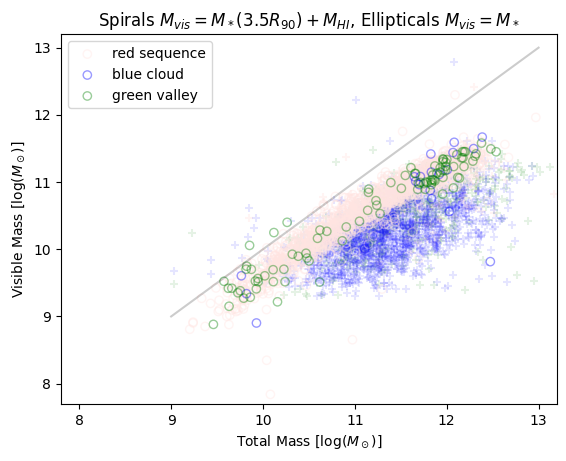

In [178]:
plt.scatter(spirals_HI[spirals_HI['CMD_class']==3]['M'],
            np.log10(10**spirals_HI[spirals_HI['CMD_class']==3]['M_disk']+10**spirals_HI[spirals_HI['CMD_class']==3]['logHI']),
            alpha=0.4, color='mistyrose', marker='+')

plt.scatter(spirals_HI[spirals_HI['CMD_class']==2]['M'],
            np.log10(10**spirals_HI[spirals_HI['CMD_class']==2]['M_disk']+10**spirals_HI[spirals_HI['CMD_class']==2]['logHI']),
            alpha=0.1, color='g', marker='+')

plt.scatter(spirals_HI[spirals_HI['CMD_class']==1]['M'],
            np.log10(10**spirals_HI[spirals_HI['CMD_class']==1]['M_disk']+10**spirals_HI[spirals_HI['CMD_class']==1]['logHI']),
            alpha=0.1, color='b', marker='+')


plt.scatter(Mvir[ellipticals['CMD_class'] == 3], Mstar[ellipticals['CMD_class'] == 3],
            alpha=0.4, color = 'mistyrose', label='red sequence', facecolor='none')
plt.scatter(Mvir[ellipticals['CMD_class'] == 1], Mstar[ellipticals['CMD_class'] == 1],
            color = 'b', alpha=0.4, label='blue cloud', facecolor='none')
plt.scatter(Mvir[ellipticals['CMD_class'] == 2], Mstar[ellipticals['CMD_class'] == 2],
            alpha=0.4, color = 'g', label='green valley', facecolor='none')
plt.legend()
plt.xlabel(r'Total Mass [$\log (M_\odot)$]')
plt.ylabel(r'Visible Mass [$\log (M_\odot)$]')
plt.plot([9,13],[9,13],color='k',alpha=0.2)
plt.xlim(7.8,13.2)
plt.ylim(7.7,13.2)
plt.title(r'Spirals $M_{vis} = M_*(3.5R_{90}) + M_{HI}$, Ellipticals $M_{vis}=M_*$')
plt.savefig(plot_dir + 'Mvis5.png')
plt.show()

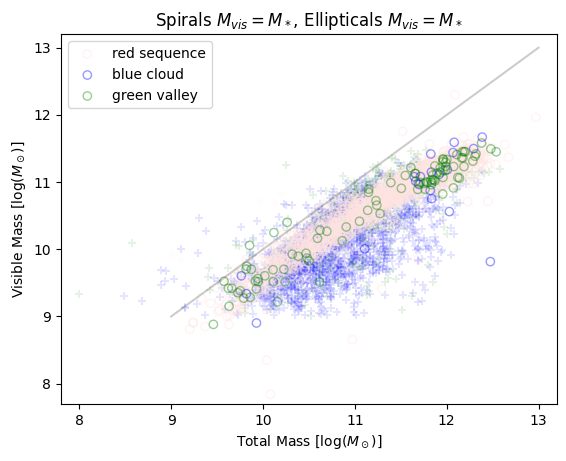

In [180]:
plt.scatter(spirals_HI_R90[spirals_HI_R90['CMD_class']==3]['M_R90'],
            spirals_HI_R90[spirals_HI_R90['CMD_class']==3]['M90_disk'],
            alpha=0.1, color='mistyrose', marker='+')

plt.scatter(spirals_HI_R90[spirals_HI_R90['CMD_class']==2]['M_R90'],
            spirals_HI_R90[spirals_HI_R90['CMD_class']==2]['M90_disk'],
            alpha=0.1, color='g', marker='+')

plt.scatter(spirals_HI_R90[spirals_HI_R90['CMD_class']==1]['M_R90'],
            spirals_HI_R90[spirals_HI_R90['CMD_class']==1]['M90_disk'],
            alpha=0.1, color='b', marker='+')


plt.scatter(Mvir[ellipticals['CMD_class'] == 3], Mstar[ellipticals['CMD_class'] == 3],
            alpha=0.4, color = 'mistyrose', label='red sequence', facecolor='none')
plt.scatter(Mvir[ellipticals['CMD_class'] == 1], Mstar[ellipticals['CMD_class'] == 1],
            color = 'b', alpha=0.4, label='blue cloud', facecolor='none')
plt.scatter(Mvir[ellipticals['CMD_class'] == 2], Mstar[ellipticals['CMD_class'] == 2],
            alpha=0.4, color = 'g', label='green valley', facecolor='none')
plt.legend()
plt.xlabel(r'Total Mass [$\log (M_\odot)$]')
plt.ylabel(r'Visible Mass [$\log (M_\odot)$]')
plt.plot([9,13],[9,13],color='k',alpha=0.2)
plt.title(r'Spirals $M_{vis} = M_*$, Ellipticals $M_{vis}=M_*$')
plt.ylim(7.7,13.2)
plt.xlim(7.8,13.2)
plt.savefig(plot_dir + 'Mvis6.png')
plt.show()